<a href="https://colab.research.google.com/github/lywgit/rlbook-hands-on/blob/main/03_frozen_lake_value_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 value iteration for Frozenlake game

- Bellman optimality equation
$$V_s = \max_{a\in A} \mathbb{E}_{s^\prime\sim S}[r_{s,a}+\gamma V_{s^\prime}] = \max_{a\in A} \sum_{s^\prime \in S}p_{a,s→s^\prime}(r_{s,a} + \gamma V_{s^\prime}) $$
- value iteration
    - state value $V$
    - action value $Q$


In [1]:
!pip install gymnasium
!pip install ale-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.7 MB/s eta 0:00:00


In [22]:
# import gymnasium as gym
# gym.pprint_registry()

## Frozenlake game visual
- 這個遊戲 action 的結果有機率跟你選的不一樣（會滑）

array([[[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]],

       [[180, 200, 230],
        [204, 230, 255],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [204, 230, 255],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       ...,

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [235, 245, 249],
        [180, 200, 230]],

       [[180, 200, 230],
        [235, 245, 249],
        [235, 245, 249],
        ...,
        [204, 230, 255],
        [204, 230, 255],
        [180, 200, 230]],

       [[180, 200, 230],
        [180, 200, 230],
        [180, 200, 230],
        ...,
        [180, 200, 230],
        [180, 200, 230],
        [180, 200, 230]]], dtype=uint8)
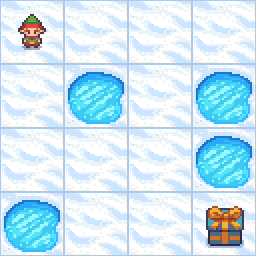

In [17]:
temp_env = gym.make('FrozenLake-v1', render_mode='rgb_array')
temp_env.reset()
temp_env.render()

## Value iteration algorithm

- 一個 episode = 玩完一次遊戲 (成功、失敗、時間到)
- 一個 step = 自 state $s$ 出發採取 action $a$ 得到環境反饋的獎勵 reward $r_{s,a}$, 並進到下一個 state $s^\prime$
    - 轉移機率：因為環境不一定是 deterministic, 在相同的 state $s$ 下採取同一種 action 不一定會有一樣的結果，以機率分佈 $p_{a,s→s^\prime}$ 表示
- value iteration algorithm 允許利用已知的「轉移機率」和「獎勵值」資料來計算馬可夫決策過程中的「狀態值 $V$」和「行動值 $Q$」
- 如果一個遊戲回合很長或是不會結束的話，每個 step 累積出來的總報酬可能會非常大，因此會用折扣因子 discount factor $\gamma$ 來降低未來 time step 的貢獻
    - $\gamma$ 介於 0 到 1 之間, 0 代表完全只考慮當下, 1 代表未來的 reward 不打折

### Learning state value $V$

Iteration: for each state $s$, update
$$V_s ← \max_{a} \sum_{s^\prime} p_{a,s→s^\prime} (r_{s,a} +\gamma V_{s^\prime})$$

- state $s$ 對應的 state value $V_s$ 代表處於 state $s$ 時預期可以得到的最佳報酬，包含兩部分:
    1. 馬上可能取得的獎勵 $r_{s,a}$
        - 處於 $s$ 時, 可以考慮所有可採取的行動及將拿到的報酬 $r_{s,a}$, 其中最高的 $r_{s,a}$ 就代表 $s$ 的價值
        - 當你進到 $s$, 只要採取對的行動就可以得到這個最高報酬, 代表 state $s$ 有這個價值
        - 實作中透過不斷跟環境度互動取得各種 $(s, a) → r_{s,a}$ 資料
    2. 下一個狀態的長期（折扣）獎勵 $s^{\prime}$ 的價值 $\gamma V_{s^\prime}$
        - 除了拿到 $r_{s,a}$ 之外, 進到 $s^\prime$ 後將能取得 $V_{s^\prime}$, 也要考慮進去


### Learning Value of Action $Q$

Iteration: for each state $s$ and action $a$, update
$$Q_{s,a} ← \sum_{s^\prime} p_{a,s→s^\prime} (r_{s,a} + \gamma \max_{a^\prime} Q_{s^\prime,a^{\prime}})$$

- 估計 state value $V$ 後續也是用於決定在 $s$ 時應該採取的最佳 $a$, 不如更直接的去評估行動的價值 value of action $Q_{s,a}$
- $Q_{s,a}$ 代表在 $s$ 的情況下採取行動 $a$ 的預期報酬，包含兩部分：
    1. 馬上可能取得的獎勵 $r_{s,a}$
    2. 下一個狀態的長期（折扣）獎勵 $\gamma \max_{a^\prime} Q_{s^\prime,a^{\prime}}$
        - 就是 state value $V_{s^\prime}$, 但用 $\max_{a^{\prime}} Q_{s^\prime,a^{\prime}}$  表達及計算


## V iteration code

In [3]:
# copied and modified from the rlbook Chap5: frozenlake_v_iteration.py

import gymnasium as gym
import collections
from torch.utils.tensorboard import SummaryWriter

ENV_NAME = "FrozenLake-v1"
GAMMA = 0.9
TEST_EPISODES = 20


class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state, _ = self.env.reset()
        self.rewards = collections.defaultdict(float) # 紀錄獎勵資料，用於更新 V
        self.transits = collections.defaultdict(collections.Counter) # 用於估計 transition 分佈，在 sum over s' 時做加權
        self.values = collections.defaultdict(float) # 這裡的 value 是 state value

    def play_n_random_steps(self, count): # 用來收集訓練資料
        for _ in range(count):
            action = self.env.action_space.sample() # 以 random action 暴力累積資料，沒有策略
            new_state, reward, terminated, truncated, _ = self.env.step(action)
            is_done = terminated or truncated
            self.rewards[(self.state, action, new_state)] = reward # dict: (s, a, s') -> r
            self.transits[(self.state, action)][new_state] += 1    # dict: (s, a) -> dict: s' -> count 紀錄的發生次數
            if is_done:
                self.state, _ = self.env.reset()
            else:
                self.state = new_state

    def calc_action_value(self, state, action): # 從目前累積的 transit & reward 資料計算 Q(s,a)
        target_counts = self.transits[(state, action)] # target_counts 是 dict: s'-> count
        total = sum(target_counts.values())
        action_value = 0.0
        for tgt_state, count in target_counts.items(): # 考慮資料中有發生過的 transition
            reward = self.rewards[(state, action, tgt_state)] # 取得 reward
            action_value += (count / total) * (reward + GAMMA * self.values[tgt_state]) # 以發生機率 p_s,a,s' ~ (count_s,a,s' / sum(count_s,a)) 加權平均 reward
        return action_value

    def select_action(self, state):
        # state 下的 best action = action 中得到 reward 最高的
        best_action, best_value = None, None
        for action in range(self.env.action_space.n):
            action_value = self.calc_action_value(state, action)
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_action

    def play_episode(self, env):
        total_reward = 0.0
        state, _ = env.reset()
        while True:
            action = self.select_action(state)
            new_state, reward, terminated, truncated, _ = env.step(action)
            is_done = terminated or truncated
            self.rewards[(state, action, new_state)] = reward
            self.transits[(state, action)][new_state] += 1
            total_reward += reward
            if is_done:
                break
            state = new_state
        return total_reward

    def value_iteration(self):
        for state in range(self.env.observation_space.n):
            # iteratively update values
            state_values = [self.calc_action_value(state, action)
                            for action in range(self.env.action_space.n)]
            self.values[state] = max(state_values)


if __name__ == "__main__":
    test_env = gym.make(ENV_NAME)
    agent = Agent()
    writer = SummaryWriter(comment="-v-iteration")

    iter_no = 0
    best_reward = 0.0
    while True:
        iter_no += 1
        # 執行一次 value iteration
        agent.play_n_random_steps(100)
        agent.value_iteration()

        # 驗證目前表現（玩 TEST_EPISODES 次的平均 reward）
        reward = 0.0
        for _ in range(TEST_EPISODES):
            reward += agent.play_episode(test_env)
        reward /= TEST_EPISODES
        writer.add_scalar("reward", reward, iter_no)
        if reward > best_reward:
            print("Best reward updated %.3f -> %.3f" % (best_reward, reward))
            best_reward = reward
        if reward > 0.80:
            print("Solved in %d iterations!" % iter_no)
            break
    writer.close()


Best reward updated 0.000 -> 0.150
Best reward updated 0.150 -> 0.300
Best reward updated 0.300 -> 0.350
Best reward updated 0.350 -> 0.400
Best reward updated 0.400 -> 0.450
Best reward updated 0.450 -> 0.650
Best reward updated 0.650 -> 0.700
Best reward updated 0.700 -> 0.750
Best reward updated 0.750 -> 0.850
Solved in 113 iterations!


## Q iteration code

In [21]:
# copied and modified from the rlbook Chap5: frozenlake_q_iteration.py
import gymnasium as gym
import collections
from torch.utils.tensorboard import SummaryWriter

ENV_NAME = "FrozenLake-v1"
GAMMA = 0.9
TEST_EPISODES = 20


class Agent:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state, _ = self.env.reset()
        self.rewards = collections.defaultdict(float)
        self.transits = collections.defaultdict(collections.Counter)
        self.values = collections.defaultdict(float) # 注意：這裡的 value 是 action value

    def play_n_random_steps(self, count):
        for _ in range(count):
            action = self.env.action_space.sample()
            new_state, reward, terminated, truncated, _ = self.env.step(action)
            is_done = terminated or truncated
            self.rewards[(self.state, action, new_state)] = reward
            self.transits[(self.state, action)][new_state] += 1
            if is_done:
                self.state,_ = self.env.reset()
            else:
                self.state = new_state

    def select_action(self, state):
        best_action, best_value = None, None
        for action in range(self.env.action_space.n):
            action_value = self.values[(state, action)]
            if best_value is None or best_value < action_value:
                best_value = action_value
                best_action = action
        return best_action

    def play_episode(self, env):
        total_reward = 0.0
        state, _ = env.reset()
        while True:
            action = self.select_action(state)
            new_state, reward, terminated, truncated, _ = env.step(action)
            is_done = terminated or truncated
            self.rewards[(state, action, new_state)] = reward
            self.transits[(state, action)][new_state] += 1
            total_reward += reward
            if is_done:
                break
            state = new_state
        return total_reward

    def value_iteration(self):
        # 改 iterate over Q(s,a)
        for state in range(self.env.observation_space.n): # over s
            for action in range(self.env.action_space.n): # over a
                action_value = 0.0
                target_counts = self.transits[(state, action)]
                total = sum(target_counts.values())
                for tgt_state, count in target_counts.items():
                    reward = self.rewards[(state, action, tgt_state)]
                    best_action = self.select_action(tgt_state)
                    action_value += (count / total) * (reward + GAMMA * self.values[(tgt_state, best_action)])
                self.values[(state, action)] = action_value # dict: (s,a) -> q


if __name__ == "__main__":
    test_env = gym.make(ENV_NAME)
    agent = Agent()
    writer = SummaryWriter(comment="-q-iteration")

    iter_no = 0
    best_reward = 0.0
    while True:
        iter_no += 1
        agent.play_n_random_steps(100)
        agent.value_iteration()

        reward = 0.0
        for _ in range(TEST_EPISODES):
            reward += agent.play_episode(test_env)
        reward /= TEST_EPISODES
        writer.add_scalar("reward", reward, iter_no)
        if reward > best_reward:
            print("Best reward updated %.3f -> %.3f" % (best_reward, reward))
            best_reward = reward
        if reward > 0.80:
            print("Solved in %d iterations!" % iter_no)
            break
    writer.close()


Best reward updated 0.000 -> 0.300
Best reward updated 0.300 -> 0.550
Best reward updated 0.550 -> 0.650
Best reward updated 0.650 -> 0.700
Best reward updated 0.700 -> 0.800
Best reward updated 0.800 -> 0.850
Solved in 36 iterations!
